## Task 1

This diagram shows the relationships between pinhole camera, image and object.

![img](pinhole.png)

Using the technique of similar triangles, the distance in optical axis($x$) can be calculated by 

$x = ObjWidth * FocalLength / ImgWidth$ ,

where $ObjWidth$ is the car average width value carfully chosen in meters by assuming that vehicles are of the same width, $FocalLength$ is the constant parameter value of the camera and $ImgWidth$ is the object width in the image in pixels.

In this case, $Objwidth$ is chosen to be $2.1m$ and $FocalLength$ is $f_y=710.3725$

Similarly, the distance vertical to x and towards right($y$) can be calculated using similar triangles using

$(x-c_x)*CameraHeight/(y-c_y)$ ,

where $c_x = 713.85, c_y=327$ defined in the camera parameter, $(x,y)$ is the point of the object in image closest to the princile point $(c_x, c_y)$ and $CameraHeight = 1.8m$ which is a constant value showing the distance from camera fo ground. 






In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
fx = 414.1526
fy = 710.3725
cx = 713.85
cy = 327.0
CarWidth = 2.1

# get position value given the bounding box value
def get_pos(top, right, bottom, left):
    width = right - left

    x = CarWidth*fy/width
    
    if abs(left-cx) < abs(right-cx):
        h = left - cx
    else:
        h = right - cx
    v = bottom - cy
    y = h/v*1.8
    return [x,y]


In [3]:
def load_json(file_name):
    with open(file_name) as f:
        data = json.load(f)
    return data

def calc_error(a, b):
    try:
        error = np.linalg.norm(np.array(a) - np.array(b)) ** 2
    except BaseException as e:
        raise Exception('Error data format')
    return error

def get_distance_label(gt):
    distance = np.linalg.norm(np.array(gt))
    if distance < 20:
        return 0
    elif distance < 45:
        return 1
    else:
        return 2

# this evaluation take the ground truth bbox value and make evaluation on the calculated position
# this dose not include the step of locating bouding box, this is purly show the 
# accuracy of calculating position
def my_evaluation():
    error_list = [[], [], []]
    for path in range(1,1075):
        data = load_json(f'benchmark_velocity_train/clips/{path}/annotation.json')
        for instance in data:
            bbox = instance['bbox']
            top = bbox['top']
            right = bbox['right']
            left = bbox['left']
            bottom = bbox['bottom']
            pos_true = instance['position']
            distance_label = get_distance_label(pos_true)
            pos_pred = get_pos(top, right, bottom, left)
            error_list[distance_label].append(calc_error(pos_true, pos_pred))
    
    pe0 = np.mean(np.array(error_list[0]))
    pe1 = np.mean(np.array(error_list[1]))
    pe2 = np.mean(np.array(error_list[2]))
    avg = (pe0 + pe1 + pe2) / 3
    print("Position Estimation error (Near): {0:.5f}".format(pe0))
    print("Position Estimation error (Medium): {0:.5f}".format(pe1))
    print("Position Estimation error (Far): {0:.5f}".format(pe2))
    print("Position Estimation error total: {0:.5f}".format(avg))
    return pe0, pe1, pe2, avg

In [4]:
my_evaluation()

Position Estimation error (Near): 8.20485
Position Estimation error (Medium): 19.40701
Position Estimation error (Far): 49.40534
Position Estimation error total: 25.67240


(8.20484735165187, 19.407005679526808, 49.405342019362756, 25.672398350180476)

The position calculation gets the least error on the near cars and gets the largest error on the cars that are far. 

Using haar car detection model

In [5]:
cascade_src = 'cars.xml'
car_cascade = cv2.CascadeClassifier(cascade_src)

# make prediction on the image using haar cascade classification and calculate the position value
def predict(img_path, vis=False):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cars = car_cascade.detectMultiScale(gray, 1.1, 1)
    pred_data = []
    for (x,y,w,h) in cars:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

        pos = get_pos(y,x+w,y+h,x)
        pred_data.append({
            'bbox': np.array([y,x,y+h,x+w]),
            'position': pos
        })
        
        cv2.putText(img, f'pos:({pos[0]:.2f},{pos[1]:.2f})m', (x, y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255))
    if vis:
        fig = plt.figure(figsize=(15,15))
        plt.imshow(img)

    return pred_data

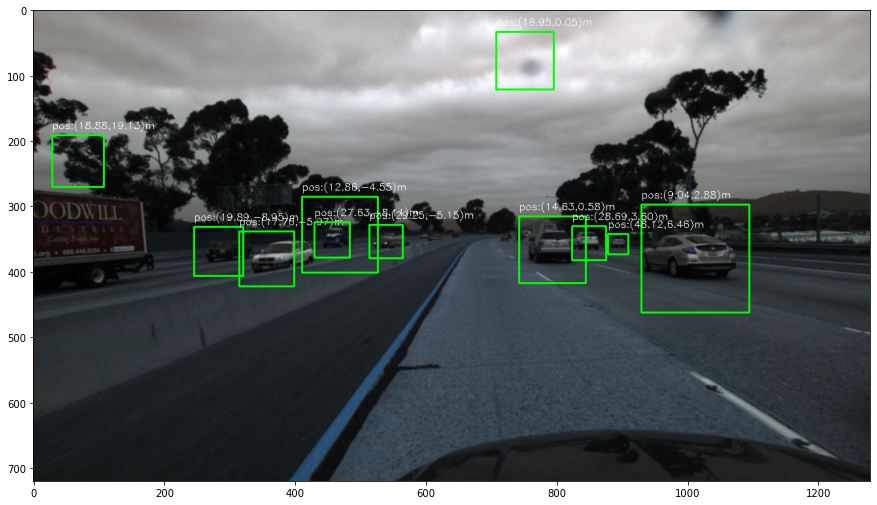

In [6]:
data = predict('benchmark_velocity_test/clips/2/imgs/040.jpg', True)

In [7]:
def transform_annotation(raw_data_list):
    anno_list = []
    for raw_data in raw_data_list:
        data = []
        for instance in raw_data:
            instance["bbox"] = np.array([[instance["bbox"]["top"],
                                            instance["bbox"]["left"],
                                            instance["bbox"]["bottom"],
                                            instance["bbox"]["right"]]])
            data.append(instance)
        anno_list.append(data)
    return anno_list

def find_nearest_pred(pred, x_gt):
    bboxes = np.vstack([p["bbox"] for p in pred])
    difference = np.sum(np.abs(np.subtract(bboxes, x_gt["bbox"])), axis=1)
    # if np.min(difference) > 10:
    #     raise Exception('We do not get all the predictions for a certain frame')
    return pred[np.argmin(difference)]

In [8]:
# The evaluation on the combined prediction on car detection and position calculation
def combined_evaluation():
    pos_error = [[], [], []]
    for path in range(1,1075):
        img_path = f'benchmark_velocity_train/clips/{path}/imgs/040.jpg'
        data = load_json(f'benchmark_velocity_train/clips/{path}/annotation.json')
        data = transform_annotation([data])
        pred_data = predict(img_path)
        for gt in data[0]:
            # print(pred_data,gt)
            pred = find_nearest_pred(pred_data, gt)
            distance_label = get_distance_label(gt['position'])
            pos_error[distance_label].append(calc_error(pred["position"], gt["position"]))
        # print(data)
    pe0 = np.mean(np.array(pos_error[0]))
    pe1 = np.mean(np.array(pos_error[1]))
    pe2 = np.mean(np.array(pos_error[2]))

    print("Position Estimation error (Near): {0:.5f}".format(pe0))
    print("Position Estimation error (Medium): {0:.5f}".format(pe1))
    print("Position Estimation error (Far): {0:.5f}".format(pe2))
    print("Position Estimation error total: {0:.5f}".format((pe0 + pe1 + pe2) / 3))

combined_evaluation()

<ipython-input-2-c21cea20b868>:18: RuntimeWarning: divide by zero encountered in double_scalars
  y = h/v*1.8
Position Estimation error (Near): 872.17459
Position Estimation error (Medium): 159.88593
Position Estimation error (Far): 598.64000
Position Estimation error total: 543.56684


The position calculation mathod itself gives a relatively lower error than the position calculation combined with haar classification car detection. The reasons could be:
 - The error produced by detection will also increase the overall error
 - The detection could not detect some ground truth vehicle bounding box where the error could reach to 100
 - The position calculation itself have error